In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
from scipy import constants as const
from numpy.fft import fft, rfft, irfft
from scipy.interpolate import griddata

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

## Обобщение на случай падающего сигнала с огибающей в форме гаусса. 

Линейная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2 = 1 \quad (2)
\end{equation}

$(1)^2$ с учётом $(2)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}  \left(\sin{(x_s - t)}\right)^2= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 + (sx_s/2)^2}
\end{equation}

Циркулярная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}
\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \cos{(x_s - t)} = \frac{s}{2}  \frac{\beta_z}{1 - \beta_x} x_s \quad \quad (2)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2+ \beta_z^2 = 1 \quad (3)
\end{equation}

$(1)^2 + (2)^2$ с учётом $(3)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} + (sx_s/2)^2}
\end{equation}

In [3]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [4]:
# для пересчёта в размерные единицы
Omega = 2.35456e+15
LightVelocity = 2.99792e+10

In [58]:
a = 40.0
n_0 = 4.0
s = n_0/a

tau = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 3.5*tau # задержка падающего импульса
T = 10*tau1 # полное время расчета
dt = 0.002 # шаг по времени

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.02:
        break
    else:
        dt += 0.0001
print(dt)

0.05050000000000042


In [59]:
x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

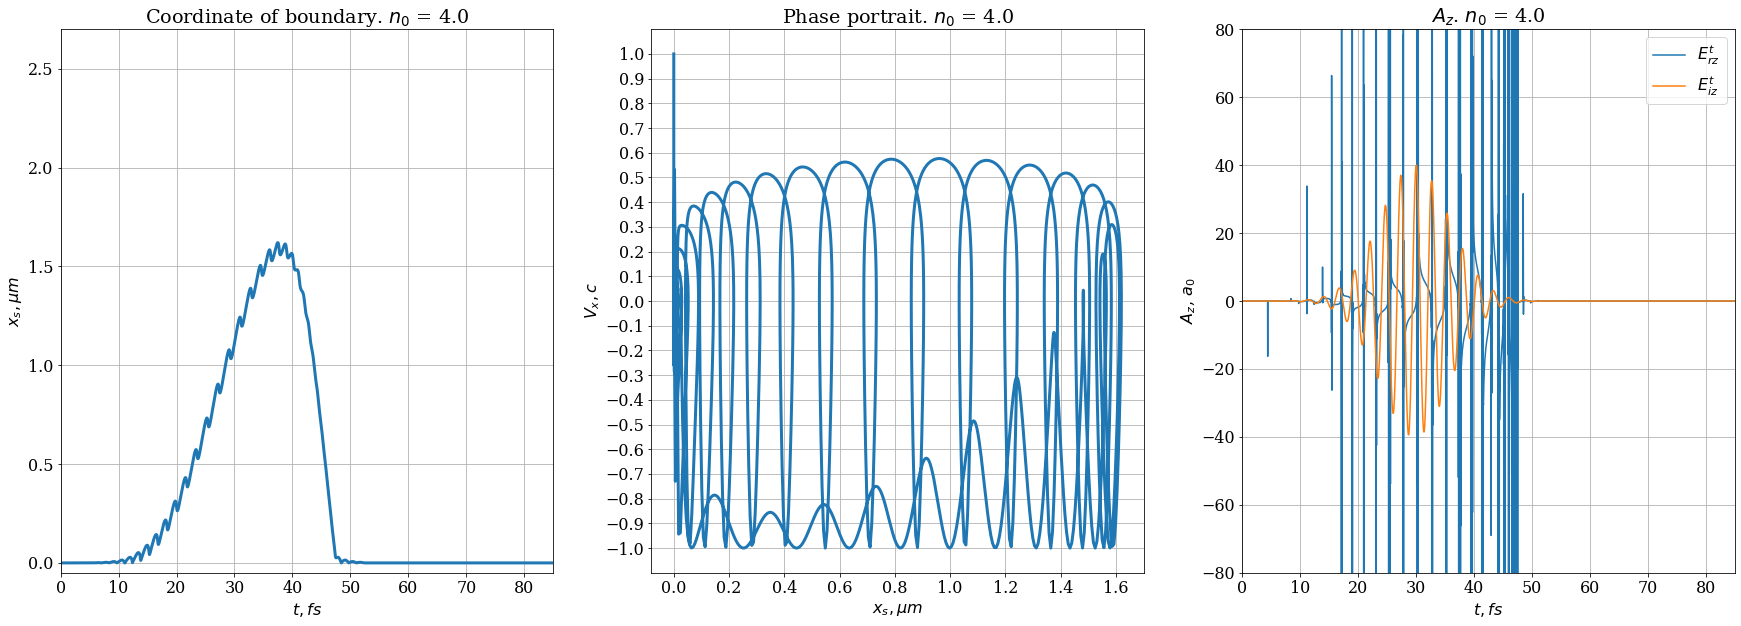

In [66]:
max_t = T/Omega*1.e+15
max_x = 2.7

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))
#plt.figure(figsize = (5,5))
ax1.plot(t[:]/Omega*1.e+15, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0)
ax1.set_xlabel(r"$t, fs$")
ax1.set_ylabel(r"$x_s, \mu m$")
ax1.set_title("Coordinate of boundary." + r" $n_0$ = {}".format(n_0))
ax1.grid()
ax1.axis([0, max_t, -0.05, max_x])
#plt.show()

#plt.figure(figsize = (5,5))
ax2.plot(x[:]*LightVelocity/Omega*1.e+4, dxdt[:], linewidth = 3.0)
ax2.set_xlabel(r"$x_s, \mu m$")
ax2.set_ylabel(r"$V_x, c$")
ax2.set_yticks(np.arange(-1.0,1.1,0.1))
ax2.set_title("Phase portrait." + r" $n_0$ = {}".format(n_0))
ax2.grid()
#plt.show()

#plt.figure(figsize = (5,5))
ax3.plot((t[1:])/Omega*1.e+15, az_r[:], label = r'$E^t_{rz}$', linewidth = 1.5)
ax3.plot(t[:]/Omega*1.e+15, az_i, label = r'$E^t_{iz}$', linewidth = 1.5)
ax3.set_title("$A_z$." + r" $n_0$ = {}".format(n_0))
ax3.set_xlabel(r"$t, fs$")
ax3.set_ylabel(r"$A_z$, $a_0$")
ax3.axis([0, max_t, -2*a, +2*a])
ax3.legend()
ax3.grid()
#plt.show()